In [1]:
import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt

ox.__version__

'1.9.4'

In [20]:
# Configuration
location = ""
start_point = (-6.255770, 106.849833)
radius_km = 30

trip_times = [15, 30, 45, 60, 90, 120]  # in minutes
default_road_speed = 5
default_train_speed = 50

# Speed based on road type.
# Traffic jam and red light baked in as part of road speed.
highway_speeds = {
    "motorway": 50,
    "trunk": 30,
    "primary": 25,
    "secondary": 20,
    "tertiary": 10,
    "residential": 10,
    "living_street": 4,
    "service": 5,
    "unclassified": 5,
    "busway": 40,
    "footway": 3,
}

poi = {
    "Start Point": (start_point[1], start_point[0]),
    "Office South Quarter": (106.785280, -6.294658),
    "Airport CGK": (106.679671, -6.116638),
    "Bundaran HI": (106.823110, -6.194950),
}

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="YlGnBu", start=0)

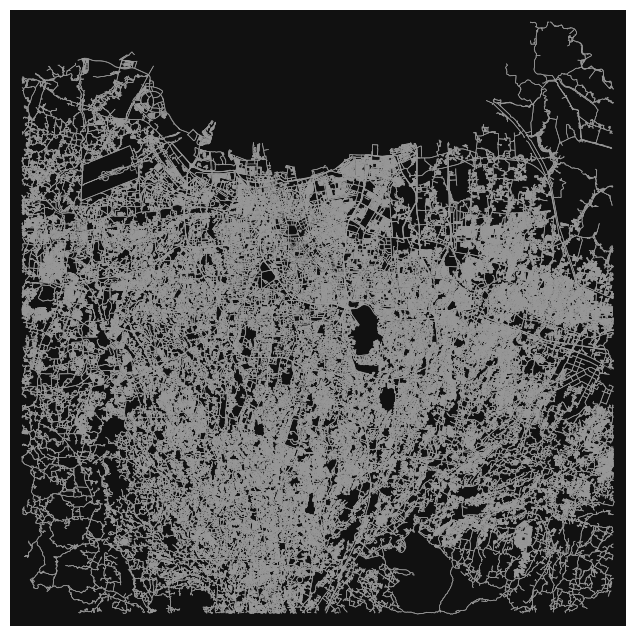

In [3]:
import os

if location:
    cache_file = f"{location}_drive.graphml"
else:
    cache_file = f"{'_'.join(map(lambda x: str(x).replace('.', '_'), start_point))}_{radius_km}_drive.graphml"

# Check if the cache file exists
if os.path.exists(cache_file):
    # Load the graph from the cache file
    G = ox.load_graphml(cache_file)
else:
    # Download the graph and save it to the cache file
    if location:
        G = ox.graph_from_place(location, network_type="drive")
    else:
        G = ox.graph_from_point(center_point=start_point, dist=radius_km*1000, network_type="drive")
    ox.save_graphml(G, cache_file)

fig, ax = ox.plot_graph(G, edge_color='#999999', edge_linewidth=0.5, node_size=0)

C:\Users\adhik\AppData\Roaming\Python\Python312\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


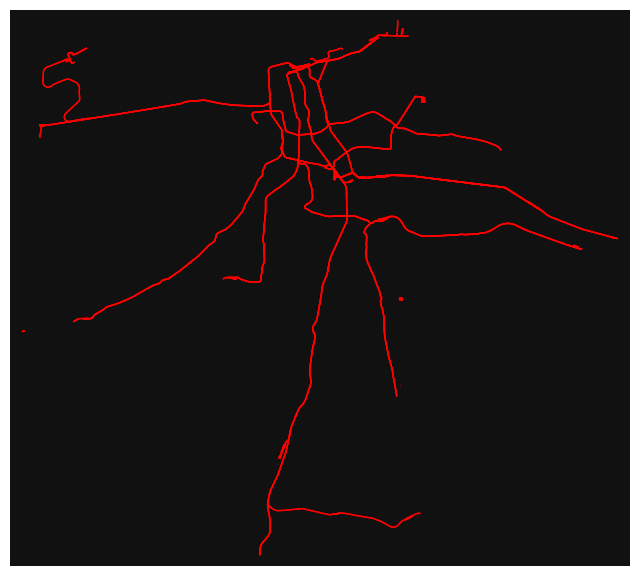

In [4]:
railway_G = ox.graph_from_point(center_point=start_point, dist=radius_km*1000, custom_filter='["railway"]', retain_all=True)
railway_G = ox.project_graph(railway_G)
# Add 'railway' attribute to each edge in railway_G
for u, v, k, data in railway_G.edges(keys=True, data=True):
    railway_G[u][v][k]['railway'] = 'train'

fig, ax = ox.plot_graph(railway_G, edge_color='#FF0000', edge_linewidth=1, node_size=0)

In [5]:
import requests
from shapely.geometry import Point
import geopandas as gpd

def get_railway_stations(center_point, radius_km):
    # Convert radius to meters
    radius_m = radius_km * 1000
    
    # Overpass API query
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
      node["railway"="station"](around:{radius_m},{center_point[0]},{center_point[1]});
    );
    out center;
    """
    
    # Send request to Overpass API
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    
    # Extract station information
    stations = []
    for element in data['elements']:
        if element['type'] == 'node':
            lat, lon = element['lat'], element['lon']
        else:  # way or relation
            lat, lon = element['center']['lat'], element['center']['lon']
        
        name = element['tags'].get('name', 'Unnamed Station')
        stations.append({
            'name': name,
            'geometry': Point(lon, lat)
        })
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(stations, crs="EPSG:4326")
    
    return gdf

# Get railway stations
railway_stations = get_railway_stations(start_point, radius_km)
print(f"Found {len(railway_stations)} railway stations.")


Found 131 railway stations.


In [6]:
from shapely.geometry import LineString, Point

# Project railway stations to the same CRS as G
railway_stations = railway_stations.to_crs(railway_G.graph['crs'])

# Function to add a node to the graph, splitting an edge if necessary
def add_node_to_graph(G, point, node_id):
    nearest_edge = ox.nearest_edges(G, X=[point.x], Y=[point.y])[0]
    u, v, key = nearest_edge
    
    # Get the geometry of the nearest edge
    edge_data = G.edges[u, v, key]
    if 'geometry' not in edge_data:
        # If there's no geometry, create a straight line between the nodes
        start_point = Point(G.nodes[u]['x'], G.nodes[u]['y'])
        end_point = Point(G.nodes[v]['x'], G.nodes[v]['y'])
        edge_geom = LineString([start_point, end_point])
    else:
        edge_geom = edge_data['geometry']
    
    # Find the nearest point on the edge geometry
    split_point = edge_geom.interpolate(edge_geom.project(point))
    
    # Get all coordinates of the original edge
    coords = list(edge_geom.coords)
    
    # Find the index where to insert the split point
    insert_index = next(i for i, coord in enumerate(coords) if LineString(coords[i:i+2]).distance(split_point) < 1e-8)
    
    # Create two new geometries, preserving all original points
    line1_coords = coords[:insert_index] + [split_point.coords[0]]
    line2_coords = [split_point.coords[0]] + coords[insert_index:]
    
    # Check if the coordinates are valid before creating LineStrings
    if len(line1_coords) > 1:
        line1 = LineString(line1_coords)
    else:
        line1 = None
    
    if len(line2_coords) > 1:
        line2 = LineString(line2_coords)
    else:
        line2 = None
    
    # Add the new node
    G.add_node(node_id, x=point.x, y=point.y, role="station")
    
    # Add new edges
    new_edge_data = edge_data.copy()
    if line1:
        new_edge_data['geometry'] = line1
        G.add_edge(u, node_id, **new_edge_data)
    if line2:
        new_edge_data['geometry'] = line2
        G.add_edge(node_id, v, **new_edge_data)
    
    # Remove the original edge
    G.remove_edge(u, v, key)

# Add railway stations to the graph
for idx, row in railway_stations.iterrows():
    node_id = f"station_{idx}"
    add_node_to_graph(railway_G, row.geometry, node_id)

print(f"Added {len(railway_stations)} railway stations to the graph.")

c:\Program Files\Python312\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


Added 131 railway stations to the graph.


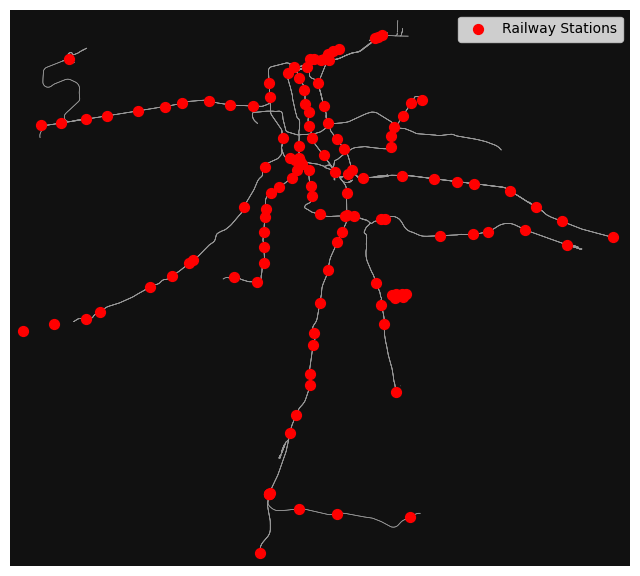

In [7]:
# Plot the railway graph with stations highlighted
fig, ax = ox.plot_graph(railway_G, node_size=0, edge_color='#999999', edge_linewidth=0.5, show=False, close=False)

# Plot station nodes as big red markers
station_nodes = [node for node, data in railway_G.nodes(data=True) if data.get('role') == 'station']
station_coords = [(railway_G.nodes[node]['x'], railway_G.nodes[node]['y']) for node in station_nodes]
x, y = zip(*station_coords)
ax.scatter(x, y, c='red', s=50, zorder=3, label='Railway Stations')
plt.legend()
plt.show()


In [8]:
# Get the center node using global coordinates
center_node = ox.distance.nearest_nodes(G, X=106.849833, Y=-6.255770)
center_coords = G.nodes[center_node]['x'], G.nodes[center_node]['y']
G = ox.project_graph(G)

In [10]:
# Create a copy of G to work with
road_and_rail_G = G

# Connect road nodes to nearest railway nodes
from tqdm import tqdm

connected_count = 0
railway_station_nodes = [(n, data) for n, data in railway_G.nodes(data=True) if data.get('role') == 'station']
for station_node, data in tqdm(railway_station_nodes, desc="Processing train stations", unit="station"):
    nearest_road_node, distance = ox.distance.nearest_nodes(
        road_and_rail_G, 
        X=data['x'], 
        Y=data['y'], 
        return_dist=True)
    if nearest_road_node:
        road_and_rail_G.add_node(station_node, **data)
        road_and_rail_G.add_edge(
            station_node, nearest_road_node, 
            length=distance, 
            highway='footway', 
            railway='connection',
            oneway='no',
            geometry=LineString([
                Point(road_and_rail_G.nodes[station_node]['x'], road_and_rail_G.nodes[station_node]['y']), 
                Point(road_and_rail_G.nodes[nearest_road_node]['x'], road_and_rail_G.nodes[nearest_road_node]['y'])
            ])
        )
        road_and_rail_G.add_edge(
            nearest_road_node, station_node,
            length=distance,
            highway='footway',
            railway='connection',
            oneway='no',
            geometry=LineString([
                Point(road_and_rail_G.nodes[nearest_road_node]['x'], road_and_rail_G.nodes[nearest_road_node]['y']),
                Point(road_and_rail_G.nodes[station_node]['x'], road_and_rail_G.nodes[station_node]['y'])
            ])
        )
        connected_count += 1

existing_nodes = set(road_and_rail_G.nodes())
existing_edges = set(road_and_rail_G.edges())

# Combine road and railway networks using networkx compose
road_and_rail_G = nx.compose(road_and_rail_G, railway_G)

# Count the number of nodes and edges added from the railway network
nodes_added = len(set(railway_G.nodes()) - existing_nodes)
edges_added = len(set(railway_G.edges()) - existing_edges)

print(f"Added {nodes_added} nodes and {edges_added} edges from the railway network.")
print(f"Connecting train station to road: {connected_count}")

Processing train stations: 100%|██████████| 131/131 [06:49<00:00,  3.13s/station]


Added 1320 nodes and 3139 edges from the railway network.
Combined road and railway networks. Connected: 131


In [ ]:
def kmh_to_mpm(kmh):
    return kmh * 1000 / 60

railway_count = 0
highway_count = 0
else_count = 0
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in road_and_rail_G.edges(data=True, keys=True):
    if "highway" in data:
        highway_type = data.get("highway", "")
        if isinstance(highway_type, list):
            highway_type = highway_type[0] if highway_type else ""
        speed = highway_speeds.get(highway_type, default_road_speed)
        highway_count += 1
    elif "railway" in data:
        railway_count += 1
        speed = default_train_speed
    else:
        speed = default_road_speed
        else_count += 1
    
    meters_per_minute = kmh_to_mpm(speed)
    data["time"] = data["length"] / meters_per_minute

print(f"Counted travel time for: Highway: {highway_count}, Railway: {railway_count}, Else: {else_count}")

Highway: 996644, Railway: 3187, Else: 0


Time taken for 120 minutes: 17.58 seconds
Time taken for 90 minutes: 16.55 seconds
Time taken for 60 minutes: 12.65 seconds
Time taken for 45 minutes: 4.26 seconds
Time taken for 30 minutes: 4.51 seconds
Time taken for 15 minutes: 0.18 seconds


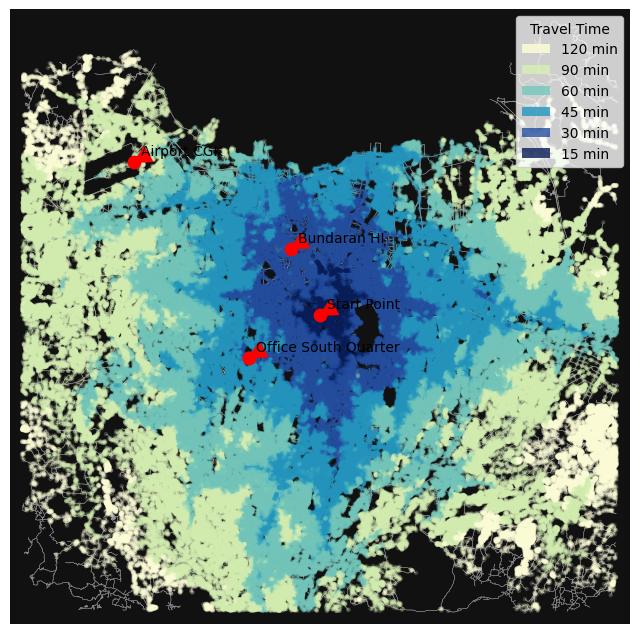

In [21]:
from matplotlib import pyplot as plt
from shapely.geometry import Point
import time

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    start_time = time.time()
    subgraph = nx.ego_graph(road_and_rail_G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
    end_time = time.time()
    print(f"Time taken for {trip_time} minutes: {end_time - start_time:.2f} seconds")

nc = [node_colors[node] if node in node_colors else "none" for node in road_and_rail_G.nodes()]
ns = [10 if node in node_colors else 0 for node in road_and_rail_G.nodes()]

fig: plt.Figure
ax: plt.Axes
fig, ax = ox.plot_graph(
    road_and_rail_G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.2,
    edge_linewidth=0.3,
    edge_color="#999999",
    show=False,
)

# Add markers for each POI
for name, (lon, lat) in poi.items():
    projected_lon = ox.projection.project_geometry(Point(lon, lat), to_crs=road_and_rail_G.graph['crs'])[0].coords[0][0]
    projected_lat = ox.projection.project_geometry(Point(lon, lat), to_crs=road_and_rail_G.graph['crs'])[0].coords[0][1]
    ax.scatter(projected_lon, projected_lat, c='r', s=80, zorder=5, label=name)
    ax.annotate(name, (projected_lon, projected_lat), xytext=(5, 5), textcoords='offset points')

# add labels for each travel time
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color, ec="none", alpha=0.8) 
                   for color in iso_colors]
legend_labels = [f"{time} min" for time in sorted(trip_times, reverse=True)]
ax.legend(legend_elements, legend_labels, loc="upper right", title="Travel Time")

plt.show()

In [15]:
%%script false --no-raise-error

from shapely.geometry import LineString, Point, Polygon, MultiPolygon
import geopandas as gpd
import numpy as np

def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []

    # Pre-compute node geometries
    node_points = [Point((data["x"], data["y"])) for _, data in G.nodes(data=True)]
    nodes_gdf = gpd.GeoDataFrame({"id": list(G.nodes)}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index("id")
    
    # Pre-compute node buffers if needed
    if node_buff > 0:
        node_buffers = nodes_gdf.buffer(node_buff).geometry
    
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
        
        # Use vectorized operations for edge geometries
        edges = list(subgraph.edges())
        edge_geoms = []
        for n_fr, n_to in edges:
            try:
                edge = G.get_edge_data(n_fr, n_to)
                if len(edge) < 1:
                    continue
                geom = edge[0].get("geometry")
                if geom is None:
                    geom = LineString([nodes_gdf.loc[n_fr].geometry, nodes_gdf.loc[n_to].geometry])
                edge_geoms.append(geom)
            except KeyError:
                # If KeyError occurs, continue to the next iteration
                continue
        
        # Compute edge buffers in bulk
        if edge_buff > 0:
            edge_buffers = gpd.GeoSeries(edge_geoms).buffer(edge_buff)
        else:
            edge_buffers = gpd.GeoSeries(edge_geoms)
        
        # Combine node and edge geometries
        if node_buff > 0:
            all_geoms = list(node_buffers.loc[subgraph.nodes()]) + list(edge_buffers)
        else:
            all_geoms = list(edge_buffers)
        
        new_iso = gpd.GeoSeries(all_geoms).unary_union

        if infill:
            if isinstance(new_iso, MultiPolygon):
                new_iso = max(new_iso.geoms, key=lambda p: p.area)
            if isinstance(new_iso, Polygon):
                new_iso = Polygon(new_iso.exterior)
        
        isochrone_polys.append(new_iso)
    
    return isochrone_polys

# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=100, node_buff=0, infill=False)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

Couldn't find program: 'false'


In [16]:
%%script false --no-raise-error

from matplotlib import pyplot as plt

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)

# add center node
center_node_coords = G.nodes[center_node]
ax.scatter(center_node_coords['x'], center_node_coords['y'], c='red', s=50, zorder=5)

# add labels for each travel time
# Create a legend instead of annotations
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color, ec="none", alpha=0.8) 
                   for color in iso_colors]
legend_labels = [f"{time} min" for time in sorted(trip_times, reverse=True)]
ax.legend(legend_elements, legend_labels, loc="upper right", title="Travel Time")

plt.show()

Couldn't find program: 'false'
